# Assignment 10 - NLP 
Version: Jun-2019

## Author - Mandar Pophali

# NLP - Sentiment Analysis

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).


In [1]:
# Import necessary libraries
import csv
import lda
import editdistance
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
# Specialty libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import argparse
import pprint
import gensim

In [39]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head(10))

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...
5                0  @Fearnecotton who sings 'I Remember'? i always...
6                4       With God on ur side anything is possible....
7                0                        @LoveSmrs why being stupid?
8                0  Having delved back into the guts of Expression...
9                0                @emoskank awww   take him with you!


In [40]:
# But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment.
df.sentiment_label=df.sentiment_label.replace(4,1)

# Check the Data frame again
print(df.head())

print('\n\n{}'.format(df['sentiment_label'].describe()))

print('\n\n Count of positives: {}'.format(np.sum(df['sentiment_label'])))

   sentiment_label                                         tweet_text
0                1  @elephantbird Hey dear, Happy Friday to You  A...
1                1  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


count    160000.000000
mean          0.500000
std           0.500002
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: sentiment_label, dtype: float64


 Count of positives: 80000


In [41]:
# Create a function preprocess the tweet data
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

In [42]:
# Clean tweets
steps = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))
df.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday already ric...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting zeina cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach reckon hell play even he know noth...
3,0,@vaLewee I know! Saw it on the news!,valewee know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad httpwwwfabchannelcom closed one web servic...


Q1: Generate word cloud for positive sentiment.

In [43]:
import numpy as np
positive_tweet_data = df['clean_tweet'][df['sentiment_label'] == 1].values.tolist()
negative_tweet_data = df['clean_tweet'][df['sentiment_label'] == 0].values.tolist()

#create the vocabulary
def vocab(tweet_data):
    vocab = set()
    for text in tweet_data:
        words = text.split(' ')
        vocab.update(set(words))
    vocab_list = list(vocab)
    return vocab_list

print('Vocabulary Size: {} distinct positive words.\n'.format(len(vocab(positive_tweet_data))))


Vocabulary Size: 91977 distinct positive words.



Q2: Generate word cloud for negative sentiment.

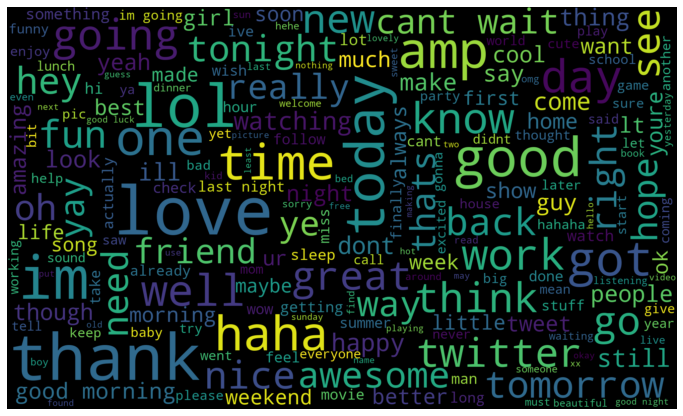

In [44]:
#!pip install wordcloud
#create a cloud graph for positive tweets
pos_tweet_text = pd.Series(positive_tweet_data).str.cat(sep=' ')
pos_tweet_text[:100]

from wordcloud import WordCloud
wordcloud = WordCloud(width=2000, height=1200, max_font_size=200).generate(pos_tweet_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Vocabulary Size: 77428 distinct negative words.



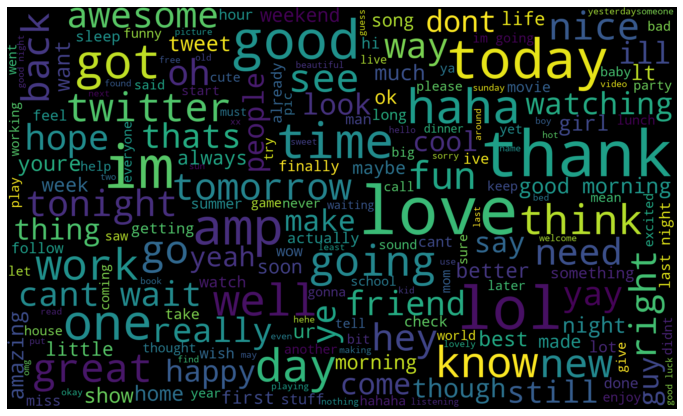

In [45]:
print('Vocabulary Size: {} distinct negative words.\n'.format(len(vocab(negative_tweet_data))))

#create clound graph for negative sentiments

neg_tweet_text = pd.Series(positive_tweet_data).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(width=2000, height=1200, max_font_size=200).generate(neg_tweet_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Q3: Split data into 70% for training and 30% for testing.

In [46]:
#generate CountVectorizer to get term frequencies 

from sklearn.feature_extraction.text import CountVectorizer
cvector = CountVectorizer(min_df = 0.0, max_df = 1.0, ngram_range=(1,2))
cvector.fit(df['clean_tweet'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [47]:
len(cvector.get_feature_names())

832896

Count vectorizer has gound 832896 words out of the entire corpus of tweets. lets review the frequencies of each word to understand the tweet data

In [48]:
pos_matrix = cvector.transform(df['clean_tweet'][df['sentiment_label'] == 1])
neg_matrix = cvector.transform(df['clean_tweet'][df['sentiment_label'] == 0])

In [50]:
#top 10 term words in negative tweets
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])
neg_tf.head(10)

,Terms,negative
0,im,10407
1,day,4945
2,get,4851
3,go,4768
4,work,4514
5,dont,4454
6,cant,4374
7,like,4090
8,today,3723
9,got,3374


In [53]:
#top 10 term words in postive tweets
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_tf.head(10)

,Terms,positive
0,im,7417
1,good,6208
2,day,5452
3,love,4985
4,get,3913
5,like,3811
6,thanks,3370
7,time,3336
8,lol,3280
9,going,3095


In [57]:
#frequency plot for top 500 words for both sentiments

#concat both frequency terms
neg_tf_df = neg_tf.set_index('Terms')
pos_tf_df = pos_tf.set_index('Terms')

term_freq_df = pd.concat([neg_tf_df,pos_tf_df],axis=1,sort=True)
term_freq_df['total'] = term_freq_df['negative']  +  term_freq_df['positive'] 
term_freq_df.sort_values(by='total', ascending=False).head(20)

,negative,positive,total
im,10407,7417,17824
day,4945,5452,10397
good,2934,6208,9142
get,4851,3913,8764
like,4090,3811,7901
go,4768,3018,7786
today,3723,3032,6755
dont,4454,2215,6669
love,1641,4985,6626
work,4514,2076,6590


The words needs to be seen in the context for positive and negative sentiments. Same words can be part of either positive or negative tweets. Strong positive words like **love,good** are more in positive sentiments than negative sentiments. While more negative words like **Cant** are more in negative sentiments. 

Text(0.5, 1.0, 'Top 100 tokens in negative tweets')

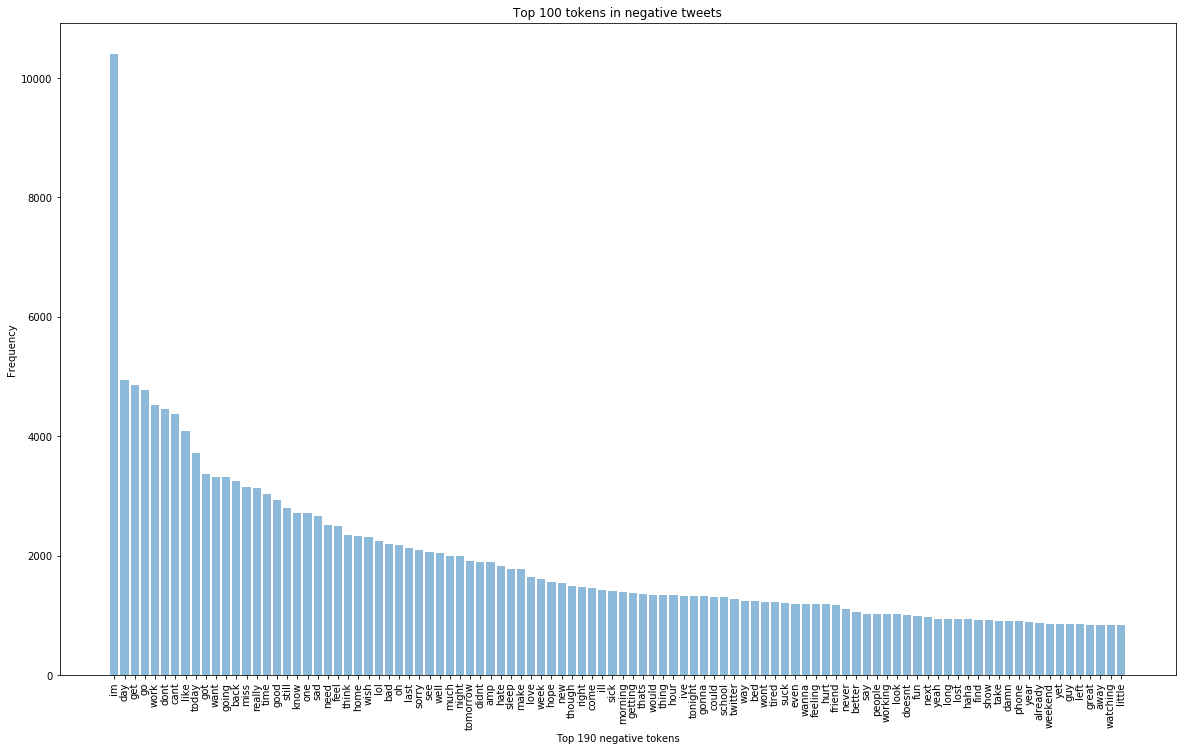

In [63]:
#top 100 negative words in the tweets
y_pos = np.arange(100)
plt.figure(figsize=(20,12))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:100], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:100].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 190 negative tokens')
plt.title('Top 100 tokens in negative tweets')

Text(0.5, 1.0, 'Top 100 tokens in positive tweets')

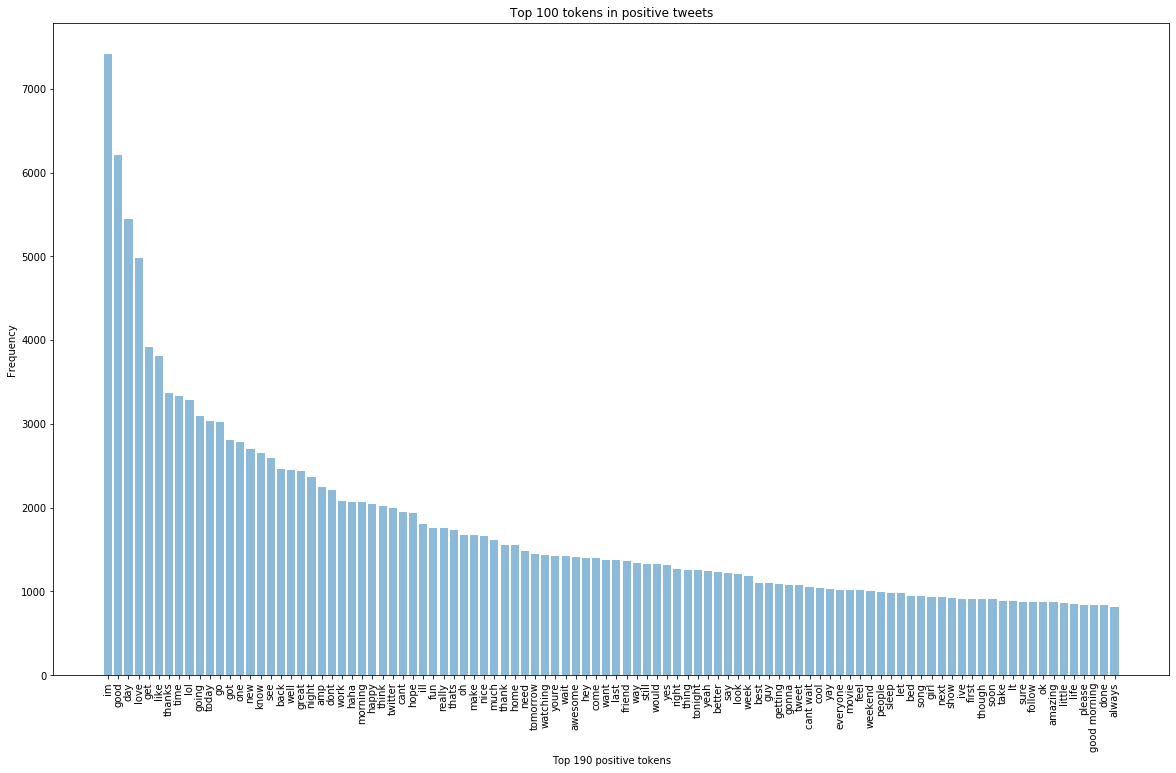

In [65]:
#top 100 postive words in the tweets
y_pos = np.arange(100)
plt.figure(figsize=(20,12))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:100], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:100].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 190 positive tokens')
plt.title('Top 100 tokens in positive tweets')

In [95]:
term_freq_df['total'][term_freq_df['total'] > 20].count()

7201

### There are more than 11703 features having more than 12 occurance. Lets use this as hyperparameter for vectorizer

In [96]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=7200, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)


# Generate 50,000 random row indices
print('Splitting into train-test. Please wait!')
from sklearn.model_selection import train_test_split

# Convert a copy of the tweets as list for use later
tweet_data = df.values.tolist()

y_targets = np.array([y[0] for y in tweet_data])

X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=50000,
                                                    random_state=42)
print('Done!')

Splitting into train-test. Please wait!
Done!


Q4: Build a classifier that classifies the sentiment of a sentence.

In [135]:
#logistic classifier on the data
print('Starting a standard Logistic Model training!')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1',tol= 0.001, C=0.4,solver = 'liblinear',max_iter=100000)
lr.fit(X_train, y_train)
print('Done.')

Starting a standard Logistic Model training!
Done.


In [136]:
lr

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)

Q5: What is the accuracy of your model when applied to testing data?

In [137]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [138]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7622909090909091
Test accuracy: 0.75112


**Iteration 1:** max_features=11703
Train accuracy: 0.7916909090909091
Test accuracy: 0.75686

The training accuracy is 0.79 which is slight more than the test accuracy. there is element of overfitting. I am goign to try reduce the max_features to 7200 and see how it impacts the accuracy

**Iteration 2:** max_features=7200
Train accuracy: 0.7829454545454545
Test accuracy: 0.75506

the training accurcy marginally came down but not much.

**Iteration 3**: max_features=7200
Train accuracy: 0.7623181818181818
Test accuracy: 0.75112
I managed to tweak some regression parameters as penalty = 'l1',tol= 0.001, C=0.4,solver = 'liblinear',max_iter=100000 and gave me results for training/testing much closer as expected. 


Q6: What conclusions can you draw from the model?

This is very basic model and gives average performance in terms on accuracy. NLTK has tweettokenizer which may provide better results.

Q7: Is it better to have a model per source?